In [ ]:
print("aaa")

In [2]:
!pip install transformers timm

     ---------------------------------------- 0.0/43.7 kB ? eta -:--:--
     ----------------- -------------------- 20.5/43.7 kB 640.0 kB/s eta 0:00:01
     -------------------------------------- 43.7/43.7 kB 530.4 kB/s eta 0:00:00
     ---------------------------------------- 0.0/53.8 kB ? eta -:--:--
     ---------------------------------------- 53.8/53.8 kB 2.9 MB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 1.0 MB/s eta 0:00:00
  Using cached tokenizers-0.19.1-cp39-none-win_amd64.whl.metadata (6.9 kB)
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/9.5 MB 3.3 MB/s eta 0:00:03
   - -------------------------------------- 0.3/9.5 MB 3.3 MB/s eta 0:00:03
   -- ----------

In [3]:
!pip install transformers

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm  # İlerleme çubuğu için
import seaborn as sns
import os

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/kidney_image2graph_all'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "resnetv2_50x1_bitm_in21k",
    "densenet121",
    "xception",
    "tf_efficientnetv2_m",
    "rexnet_300",
    "repvgg_b0",
    "inception_v4",
    "efficientnet_b3",
    "mobilenetv3_large_100",
    "convnext_base",
    "mobilevit_s",
    "vit_base_patch16_224",
    "deit_base_patch16_224",
    "beit_base_patch16_224",
    "pit_s",
    "gc_vit_base",
    "nextvit_base",
    "tinyvit_21m",
    "maxvit_base",
    "swin_base_patch4_window7_224"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=len(train_dataset.classes))
    return model

# Erken durdurma fonksiyonu
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss >= self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, sensitivity, specificity, precision, recall, f1

# Eğitim ve Değerlendirme Döngüsü
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, num_epochs=50, patience=5):
    results_table = []
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(num_epochs):
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Eğitim Aşaması
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        progress_bar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(logits, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
        
        train_accuracy = train_correct / train_total

        # Doğrulama Aşaması
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_labels = []
        all_preds = []
        progress_bar = tqdm(test_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for images, labels in progress_bar:
                images = images.to(device)
                labels = labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                _, preds = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                progress_bar.set_postfix(loss=loss.item())
        
        val_accuracy = val_correct / val_total

        # Performans Metriklerini Hesapla
        conf_matrix = confusion_matrix(all_labels, all_preds)
        accuracy, sensitivity, specificity, precision, recall, f1 = compute_metrics(conf_matrix)
        results_table.append({
            'Epoch': epoch + 1,
            'Train Loss': train_loss / len(train_loader),
            'Validation Loss': val_loss / len(test_loader),
            'Train Accuracy': train_accuracy,
            'Validation Accuracy': val_accuracy,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': conf_matrix
        })

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(test_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Accuracy: {accuracy:.4f}, "
              f"Sensitivity: {sensitivity:.4f}, "
              f"Specificity: {specificity:.4f}, "
              f"Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, "
              f"F1 Score: {f1:.4f}")

        early_stopping(val_loss)
        
    return pd.DataFrame(results_table)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = {}
combined_results = []
conf_matrices = []

for model_name in model_names:
    try:
        print(f"Training {model_name} model...")
        model = get_model(model_name).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        results_df = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, num_epochs=50, patience=5)
        all_results[model_name] = results_df
        
        # Sonuçları her bir model için ayrı bir CSV dosyasına kaydet
        results_df.to_csv(f'results_{model_name}.csv', index=False)

        # Sonuçları tek bir DataFrame'e ekle
        results_df['Model'] = model_name
        combined_results.append(results_df)
        
        # Confusion Matrix'i sakla
        conf_matrix = results_df.iloc[-1]['Confusion Matrix']
        conf_matrices.append((model_name, conf_matrix))
        
        # Confusion Matrix'i çiz ve kaydet
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'confusion_matrix_{model_name}.png')
        plt.close()
        
        # Accuracy ve Loss grafikleri
        epochs = results_df['Epoch']
        plt.figure()
        plt.plot(epochs, results_df['Train Accuracy'], label='Train Accuracy')
        plt.plot(epochs, results_df['Validation Accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy over Epochs for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(f'accuracy_{model_name}.png')
        plt.close()
        
        plt.figure()
        plt.plot(epochs, results_df['Train Loss'], label='Train Loss')
        plt.plot(epochs, results_df['Validation Loss'], label='Validation Loss')
        plt.title(f'Loss over Epochs for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'loss_{model_name}.png')
        plt.close()

    except Exception as e:
        print(f"An error occurred while training {model_name}: {e}")
        continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.concat(combined_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy ve loss grafiklerini karşılaştırmalı olarak çiz
epochs = range(1, 51)
plt.figure(figsize=(20, 10))
for model_name in all_results:
    results_df = all_results[model_name]
    plt.plot(epochs, results_df['Validation Accuracy'], label=f'{model_name} Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('validation_accuracy_comparison.png')
plt.close()

plt.figure(figsize=(20, 10))
for model_name in all_results:
    results_df = all_results[model_name]
    plt.plot(epochs, results_df['Validation Loss'], label=f'{model_name} Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.savefig('validation_loss_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (model_name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()


c:\Users\Mitam\anaconda3\envs\tf39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training resnetv2_50x1_bitm_in21k model...


c:\Users\Mitam\anaconda3\envs\tf39\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name resnetv2_50x1_bitm_in21k to current resnetv2_50x1_bit.goog_in21k.
  model = create_fn(


Epoch 1/50


An error occurred while training resnetv2_50x1_bitm_in21k: too many values to unpack (expected 4)
Training densenet121 model...
Epoch 1/50


c:\Users\Mitam\anaconda3\envs\tf39\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


An error occurred while training densenet121: too many values to unpack (expected 4)
Training xception model...
Epoch 1/50


An error occurred while training xception: too many values to unpack (expected 4)
Training tf_efficientnetv2_m model...
Epoch 1/50


An error occurred while training tf_efficientnetv2_m: too many values to unpack (expected 4)
Training rexnet_300 model...
Epoch 1/50


An error occurred while training rexnet_300: too many values to unpack (expected 4)
Training repvgg_b0 model...
Epoch 1/50


An error occurred while training repvgg_b0: too many values to unpack (expected 4)
Training inception_v4 model...
Epoch 1/50


An error occurred while training inception_v4: too many values to unpack (expected 4)
Training efficientnet_b3 model...
Epoch 1/50


An error occurred while training efficientnet_b3: too many values to unpack (expected 4)
Training mobilenetv3_large_100 model...
Epoch 1/50


An error occurred while training mobilenetv3_large_100: too many values to unpack (expected 4)
Training convnext_base model...
Epoch 1/50


An error occurred while training convnext_base: too many values to unpack (expected 4)
Training mobilevit_s model...
Epoch 1/50


An error occurred while training mobilevit_s: too many values to unpack (expected 4)
Training vit_base_patch16_224 model...
Epoch 1/50


An error occurred while training vit_base_patch16_224: too many values to unpack (expected 4)
Training deit_base_patch16_224 model...
Epoch 1/50


An error occurred while training deit_base_patch16_224: too many values to unpack (expected 4)
Training beit_base_patch16_224 model...
Epoch 1/50


An error occurred while training beit_base_patch16_224: too many values to unpack (expected 4)
Training pit_s model...
An error occurred while training pit_s: Unknown model (pit_s)
Training gc_vit_base model...
An error occurred while training gc_vit_base: Unknown model (gc_vit_base)
Training nextvit_base model...
Epoch 1/50


An error occurred while training nextvit_base: too many values to unpack (expected 4)
Training tinyvit_21m model...
An error occurred while training tinyvit_21m: Unknown model (tinyvit_21m)
Training maxvit_base model...
An error occurred while training maxvit_base: Unknown model (maxvit_base)
Training swin_base_patch4_window7_224 model...
Epoch 1/50


An error occurred while training swin_base_patch4_window7_224: too many values to unpack (expected 4)


ValueError: No objects to concatenate

## CNN Modeller #

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm  # İlerleme çubuğu için
import seaborn as sns
import os

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/kidney_image2graph_all'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "resnetv2_50x1_bitm_in21k",
    "densenet121",
    "xception",
    "tf_efficientnetv2_m",
    "rexnet_300",
    "repvgg_b0",
    "inception_v4",
    "efficientnet_b3",
    "mobilenetv3_large_100",
    "convnext_base",
    "mobilevit_s",
    "vit_base_patch16_224",
    "deit_base_patch16_224",
    "beit_base_patch16_224",
    "pit_s",
    "gc_vit_base",
    "nextvit_base",
    "tinyvit_21m",
    "maxvit_base",
    "swin_base_patch4_window7_224"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=len(train_dataset.classes))
    return model

# Erken durdurma fonksiyonu
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss >= self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, sensitivity, specificity, precision, recall, f1

# Eğitim ve Değerlendirme Döngüsü
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, num_epochs=50, patience=5):
    results_table = []
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(num_epochs):
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Eğitim Aşaması
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        progress_bar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(logits, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
        
        train_accuracy = train_correct / train_total

        # Doğrulama Aşaması
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_labels = []
        all_preds = []
        progress_bar = tqdm(test_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for images, labels in progress_bar:
                images = images.to(device)
                labels = labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                _, preds = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                progress_bar.set_postfix(loss=loss.item())
        
        val_accuracy = val_correct / val_total

        # Performans Metriklerini Hesapla
        conf_matrix = confusion_matrix(all_labels, all_preds)
        accuracy, sensitivity, specificity, precision, recall, f1 = compute_metrics(conf_matrix)
        results_table.append({
            'Epoch': epoch + 1,
            'Train Loss': train_loss / len(train_loader),
            'Validation Loss': val_loss / len(test_loader),
            'Train Accuracy': train_accuracy,
            'Validation Accuracy': val_accuracy,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': conf_matrix
        })

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(test_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Accuracy: {accuracy:.4f}, "
              f"Sensitivity: {sensitivity:.4f}, "
              f"Specificity: {specificity:.4f}, "
              f"Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, "
              f"F1 Score: {f1:.4f}")

        early_stopping(val_loss)
        
    return pd.DataFrame(results_table)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = {}
combined_results = []
conf_matrices = []

for model_name in model_names:
    try:
        print(f"Training {model_name} model...")
        model = get_model(model_name).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        results_df = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, num_epochs=50, patience=5)
        all_results[model_name] = results_df
        
        # Sonuçları her bir model için ayrı bir CSV dosyasına kaydet
        results_df.to_csv(f'results_{model_name}.csv', index=False)

        # Sonuçları tek bir DataFrame'e ekle
        results_df['Model'] = model_name
        combined_results.append(results_df)
        
        # Confusion Matrix'i sakla
        conf_matrix = results_df.iloc[-1]['Confusion Matrix']
        conf_matrices.append((model_name, conf_matrix))
        
        # Confusion Matrix'i çiz ve kaydet
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'confusion_matrix_{model_name}.png')
        plt.close()
        
        # Accuracy ve Loss grafikleri
        epochs = results_df['Epoch']
        plt.figure()
        plt.plot(results_df['Epoch'], results_df['Train Accuracy'], label='Train Accuracy')
        plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy over Epochs for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(f'accuracy_{model_name}.png')
        plt.close()
        
        plt.figure()
        plt.plot(results_df['Epoch'], results_df['Train Loss'], label='Train Loss')
        plt.plot(results_df['Epoch'], results_df['Validation Loss'], label='Validation Loss')
        plt.title(f'Loss over Epochs for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'loss_{model_name}.png')
        plt.close()

    except Exception as e:
        print(f"An error occurred while training {model_name}: {e}")
        continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.concat(combined_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy ve loss grafiklerini karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for model_name in all_results:
    results_df = all_results[model_name]
    plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], label=f'{model_name} Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('validation_accuracy_comparison.png')
plt.close()

plt.figure(figsize=(20, 10))
for model_name in all_results:
    results_df = all_results[model_name]
    plt.plot(results_df['Epoch'], results_df['Validation Loss'], label=f'{model_name} Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.savefig('validation_loss_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (model_name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()


c:\Users\Mitam\anaconda3\envs\tf39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training resnetv2_50x1_bitm_in21k model...


c:\Users\Mitam\anaconda3\envs\tf39\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name resnetv2_50x1_bitm_in21k to current resnetv2_50x1_bit.goog_in21k.
  model = create_fn(


Epoch 1/50


An error occurred while training resnetv2_50x1_bitm_in21k: too many values to unpack (expected 4)
Training densenet121 model...
Epoch 1/50


c:\Users\Mitam\anaconda3\envs\tf39\lib\site-packages\timm\models\_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


An error occurred while training densenet121: too many values to unpack (expected 4)
Training xception model...
Epoch 1/50


An error occurred while training xception: too many values to unpack (expected 4)
Training tf_efficientnetv2_m model...
Epoch 1/50


An error occurred while training tf_efficientnetv2_m: too many values to unpack (expected 4)
Training rexnet_300 model...
Epoch 1/50


An error occurred while training rexnet_300: too many values to unpack (expected 4)
Training repvgg_b0 model...
Epoch 1/50


An error occurred while training repvgg_b0: too many values to unpack (expected 4)
Training inception_v4 model...
Epoch 1/50


An error occurred while training inception_v4: too many values to unpack (expected 4)
Training efficientnet_b3 model...
Epoch 1/50


An error occurred while training efficientnet_b3: too many values to unpack (expected 4)
Training mobilenetv3_large_100 model...
Epoch 1/50


An error occurred while training mobilenetv3_large_100: too many values to unpack (expected 4)
Training convnext_base model...
Epoch 1/50


An error occurred while training convnext_base: too many values to unpack (expected 4)
Training mobilevit_s model...
Epoch 1/50


An error occurred while training mobilevit_s: too many values to unpack (expected 4)
Training vit_base_patch16_224 model...
Epoch 1/50


An error occurred while training vit_base_patch16_224: too many values to unpack (expected 4)
Training deit_base_patch16_224 model...
Epoch 1/50


An error occurred while training deit_base_patch16_224: too many values to unpack (expected 4)
Training beit_base_patch16_224 model...
Epoch 1/50


An error occurred while training beit_base_patch16_224: too many values to unpack (expected 4)
Training pit_s model...
An error occurred while training pit_s: Unknown model (pit_s)
Training gc_vit_base model...
An error occurred while training gc_vit_base: Unknown model (gc_vit_base)
Training nextvit_base model...
Epoch 1/50


An error occurred while training nextvit_base: too many values to unpack (expected 4)
Training tinyvit_21m model...
An error occurred while training tinyvit_21m: Unknown model (tinyvit_21m)
Training maxvit_base model...
An error occurred while training maxvit_base: Unknown model (maxvit_base)
Training swin_base_patch4_window7_224 model...
Epoch 1/50


An error occurred while training swin_base_patch4_window7_224: too many values to unpack (expected 4)


ValueError: No objects to concatenate

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm  # İlerleme çubuğu için
import seaborn as sns
import os

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/kidney_image2graph_all'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "maxvit_tiny_224",
    "maxvit_small_224",
    "maxvit_base_224",
    "maxvit_large_224",
    "deit3_small_patch16_224",
    "deit3_base_patch16_224",
    "deit3_large_patch16_224",
    "vit_small_patch32_224",
    "vit_small_patch16_224",
    "vit_base_patch32_224",
    "vit_base_patch16_224",
    "vit_large_patch16_224",
    "vit_large_patch32_224",
    "gc_vit_tiny",
    "gc_vit_xtiny",
    "gc_vit_xxtiny",
    "visformer_tiny",
    "visformer_small",
    "swinv2_tiny_window8_256",
    "swinv2_tiny_window16_256",
    "swinv2_small_window8_256",
    "swinv2_small_window16_256",
    "swinv2_base_window8_256",
    "swinv2_base_window16_256",
    "tnt_small_patch16_224",
    "eva_tiny_patch14_224",
    "eva_small_patch14_224",
    "eva_base_patch14_224",
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "twins_pcpvt_small",
    "twins_pcpvt_base",
    "mvitv2_tiny",
    "mvitv2_small",
    "mvitv2_base",
    "mvitv2_large",
    "pvtv2_b0",
    "pvtv2_b3",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200",
    "poolformerv2_s12",
    "poolformerv2_s36",
    "fastvit_sa12",
    "fastvit_sa24",
    "fastvit_sa36",
    "fastvit_ma36",
    "repvit_m1",
    "repvit_m2",
    "repvit_m3",
    "tinyvit_5m",
    "tinyvit_11m",
    "tinyvit_21m"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=len(train_dataset.classes))
    return model

# Erken durdurma fonksiyonu
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif val_loss >= self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return accuracy, sensitivity, specificity, precision, recall, f1

# Eğitim ve Değerlendirme Döngüsü
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, num_epochs=50, patience=5):
    results_table = []
    early_stopping = EarlyStopping(patience=patience)
    for epoch in range(num_epochs):
        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Eğitim Aşaması
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        progress_bar = tqdm(train_loader, desc="Training", leave=False)
        for images, labels in progress_bar:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _, preds = torch.max(logits, 1)
            train_total += labels.size(0)
            train_correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
        
        train_accuracy = train_correct / train_total

        # Doğrulama Aşaması
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_labels = []
        all_preds = []
        progress_bar = tqdm(test_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for images, labels in progress_bar:
                images = images.to(device)
                labels = labels.to(device)
                logits = model(images)
                loss = criterion(logits, labels)
                val_loss += loss.item()
                _, preds = torch.max(logits, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                progress_bar.set_postfix(loss=loss.item())
        
        val_accuracy = val_correct / val_total

        # Performans Metriklerini Hesapla
        conf_matrix = confusion_matrix(all_labels, all_preds)
        accuracy, sensitivity, specificity, precision, recall, f1 = compute_metrics(conf_matrix)
        results_table.append({
            'Epoch': epoch + 1,
            'Train Loss': train_loss / len(train_loader),
            'Validation Loss': val_loss / len(test_loader),
            'Train Accuracy': train_accuracy,
            'Validation Accuracy': val_accuracy,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Confusion Matrix': conf_matrix
        })

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(test_loader):.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, "
              f"Accuracy: {accuracy:.4f}, "
              f"Sensitivity: {sensitivity:.4f}, "
              f"Specificity: {specificity:.4f}, "
              f"Precision: {precision:.4f}, "
              f"Recall: {recall:.4f}, "
              f"F1 Score: {f1:.4f}")

        early_stopping(val_loss)
        
    return pd.DataFrame(results_table)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = {}
combined_results = []
conf_matrices = []

for model_name in model_names:
    try:
        print(f"Training {model_name} model...")
        model = get_model(model_name).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()
        results_df = train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, num_epochs=50, patience=5)
        all_results[model_name] = results_df
        
        # Sonuçları her bir model için ayrı bir CSV dosyasına kaydet
        results_df.to_csv(f'results_{model_name}.csv', index=False)

        # Sonuçları tek bir DataFrame'e ekle
        results_df['Model'] = model_name
        combined_results.append(results_df)
        
        # Confusion Matrix'i sakla
        conf_matrix = results_df.iloc[-1]['Confusion Matrix']
        conf_matrices.append((model_name, conf_matrix))
        
        # Confusion Matrix'i çiz ve kaydet
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(f'confusion_matrix_{model_name}.png')
        plt.close()
        
        # Accuracy ve Loss grafikleri
        plt.figure()
        plt.plot(results_df['Epoch'], results_df['Train Accuracy'], label='Train Accuracy')
        plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], label='Validation Accuracy')
        plt.title(f'Accuracy over Epochs for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(f'accuracy_{model_name}.png')
        plt.close()
        
        plt.figure()
        plt.plot(results_df['Epoch'], results_df['Train Loss'], label='Train Loss')
        plt.plot(results_df['Epoch'], results_df['Validation Loss'], label='Validation Loss')
        plt.title(f'Loss over Epochs for {model_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'loss_{model_name}.png')
        plt.close()

    except Exception as e:
        print(f"An error occurred while training {model_name}: {e}")
        continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.concat(combined_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy ve loss grafiklerini karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for model_name in all_results:
    results_df = all_results[model_name]
    plt.plot(results_df['Epoch'], results_df['Validation Accuracy'], label=f'{model_name} Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.savefig('validation_accuracy_comparison.png')
plt.close()

plt.figure(figsize=(20, 10))
for model_name in all_results:
    results_df = all_results[model_name]
    plt.plot(results_df['Epoch'], results_df['Validation Loss'], label=f'{model_name} Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.savefig('validation_loss_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (model_name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm  # İlerleme çubuğu için
import seaborn as sns
import os

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/kidney_image2graph_all'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "maxvit_tiny_224",
    "maxvit_small_224",
    "maxvit_base_224",
    "maxvit_large_224",
    "deit3_small_patch16_224",
    "deit3_base_patch16_224",
    "deit3_large_patch16_224",
    "vit_small_patch32_224",
    "vit_small_patch16_224",
    "vit_base_patch32_224",
    "vit_base_patch16_224",
    "vit_large_patch16_224",
    "vit_large_patch32_224",
    "gc_vit_tiny",
    "gc_vit_xtiny",
    "gc_vit_xxtiny",
    "visformer_tiny",
    "visformer_small",
    "swinv2_tiny_window8_256",
    "swinv2_tiny_window16_256",
    "swinv2_small_window8_256",
    "swinv2_small_window16_256",
    "swinv2_base_window8_256",
    "swinv2_base_window16_256",
    "tnt_small_patch16_224",
    "eva_tiny_patch14_224",
    "eva_small_patch14_224",
    "eva_base_patch14_224",
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "twins_pcpvt_small",
    "twins_pcpvt_base",
    "mvitv2_tiny",
    "mvitv2_small",
    "mvitv2_base",
    "mvitv2_large",
    "pvtv2_b0",
    "pvtv2_b3",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200",
    "poolformerv2_s12",
    "poolformerv2_s36",
    "fastvit_sa12",
    "fastvit_sa24",
    "fastvit_sa36",
    "fastvit_ma36",
    "repvit_m1",
    "repvit_m2",
    "repvit_m3",
    "tinyvit_5m",
    "tinyvit_11m",
    "tinyvit_21m"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=len(train_dataset.classes))
    model.reset_classifier(0)  # Sınıflandırıcı katmanı sıfırlanır, sadece özellik çıkarımı yapılır
    return model

# Özellik çıkarma fonksiyonu
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = []
combined_results = []

for model_name in model_names:
    try:
        print(f"Extracting features with {model_name} model...")
        model = get_model(model_name).to(device)
        
        # Eğitim ve test özelliklerini çıkar
        train_features, train_labels = extract_features(model, train_loader)
        test_features, test_labels = extract_features(model, test_loader)
        
        # Sınıflandırıcıları tanımla
        classifiers = {
            'SVM': SVC(),
            'KNN': KNeighborsClassifier(),
            'RF': RandomForestClassifier()
        }
        
        for clf_name, clf in classifiers.items():
            print(f"Training {clf_name} classifier...")
            clf.fit(train_features, train_labels)
            predictions = clf.predict(test_features)
            accuracy, precision, recall, f1 = compute_metrics(test_labels, predictions)
            
            result = {
                'Model': model_name,
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-score': f1
            }
            all_results.append(result)
            
            # Sonuçları her bir model ve sınıflandırıcı için ayrı bir CSV dosyasına kaydet
            result_df = pd.DataFrame([result])
            result_df.to_csv(f'results_{model_name}_{clf_name}.csv', index=False)

    except Exception as e:
        print(f"An error occurred while processing {model_name}: {e}")
        continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.DataFrame(all_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin performanslarını karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for clf_name in classifiers.keys():
    subset = combined_results_df[combined_results_df['Classifier'] == clf_name]
    plt.plot(subset['Model'], subset['Accuracy'], label=f'{clf_name} Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('model_accuracy_comparison.png')
plt.close()


c:\Users\Mitam\anaconda3\envs\tf39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Extracting features with maxvit_tiny_224 model...
An error occurred while processing maxvit_tiny_224: Unknown model (maxvit_tiny_224)
Extracting features with maxvit_small_224 model...
An error occurred while processing maxvit_small_224: Unknown model (maxvit_small_224)
Extracting features with maxvit_base_224 model...
An error occurred while processing maxvit_base_224: Unknown model (maxvit_base_224)
Extracting features with maxvit_large_224 model...
An error occurred while processing maxvit_large_224: Unknown model (maxvit_large_224)
Extracting features with deit3_small_patch16_224 model...
An error occurred while processing deit3_small_patch16_224: name 'np' is not defined
Extracting features with deit3_base_patch16_224 model...
An error occurred while processing deit3_base_patch16_224: name 'np' is not defined
Extracting features with deit3_large_patch16_224 model...
An error occurred while processing deit3_large_patch16_224: name 'np' is not defined
Extracting features with vit_sm

NameError: name 'classifiers' is not defined

<Figure size 2000x1000 with 0 Axes>

In [ ]:
!pip install xgboost deap

In [5]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from deap import base, creator, tools, algorithms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm
import seaborn as sns
import os

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/images2grah'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 ile özellik çıkarımı yapar
    return model

# Özellik çıkarma fonksiyonu
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Genetik Algoritma ile Özellik Seçimi
def genetic_feature_selection(features, labels):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=features.shape[1])
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def evaluate(individual):
        selected_features = features[:, [i for i, bit in enumerate(individual) if bit == 1]]
        if selected_features.shape[1] == 0:  # Hiçbir özellik seçilmediyse, kötü bir fitness değeri ver
            return 0.0,
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return accuracy,

    toolbox.register("evaluate", evaluate)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=50)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=20, verbose=False)

    best_individual = tools.selBest(population, 1)[0]
    selected_features_indices = [i for i, bit in enumerate(best_individual) if bit == 1]
    return selected_features_indices

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = []
combined_results = []

for model_name in model_names:
    try:
        print(f"Extracting features with {model_name} model...")
        model = get_model(model_name).to(device)
        
        # Eğitim ve test özelliklerini çıkar
        train_features, train_labels = extract_features(model, train_loader)
        test_features, test_labels = extract_features(model, test_loader)
        
        # Özellik seçimi ve optimizasyon
        print(f"Optimizing features for {model_name} model...")
        selected_features_indices = genetic_feature_selection(train_features, train_labels)
        optimized_train_features = train_features[:, selected_features_indices]
        optimized_test_features = test_features[:, selected_features_indices]
        
        # Sınıflandırıcıları tanımla
        classifiers = {
            'SVM': SVC(),
            'KNN': KNeighborsClassifier(),
            'RF': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        
        for clf_name, clf in classifiers.items():
            print(f"Training {clf_name} classifier...")
            clf.fit(optimized_train_features, train_labels)
            predictions = clf.predict(optimized_test_features)
            accuracy, precision, recall, f1 = compute_metrics(test_labels, predictions)
            
            result = {
                'Model': model_name,
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-score': f1
            }
            all_results.append(result)
            
            # Sonuçları her bir model ve sınıflandırıcı için ayrı bir CSV dosyasına kaydet
            result_df = pd.DataFrame([result])
            result_df.to_csv(f'results_{model_name}_{clf_name}.csv', index=False)

    except Exception as e:
        print(f"An error occurred while processing {model_name}: {e}")
        continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.DataFrame(all_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin performanslarını karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for clf_name in classifiers.keys():
    subset = combined_results_df[combined_results_df['Classifier'] == clf_name]
    plt.plot(subset['Model'], subset['Accuracy'], label=f'{clf_name} Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('model_accuracy_comparison.png')
plt.close()


ModuleNotFoundError: No module named 'deap'

In [ ]:
!pip install optuna


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm
import seaborn as sns
import optuna
import os

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/images2grah' # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 ile özellik çıkarımı yapar
    return model

# Özellik çıkarma fonksiyonu
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

# Optuna ile Özellik Seçimi ve Optimizasyonu
def optimize_with_optuna(features, labels):
    def objective(trial):
        selected_features_indices = []
        for i in range(features.shape[1]):
            if trial.suggest_categorical(f'feature_{i}', [0, 1]) == 1:
                selected_features_indices.append(i)
        
        if not selected_features_indices:  # Hiçbir özellik seçilmediyse, kötü bir fitness değeri ver
            return 0.0
        
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return accuracy
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    
    best_trial = study.best_trial
    selected_features_indices = [i for i in range(features.shape[1]) if best_trial.params[f'feature_{i}'] == 1]
    return selected_features_indices

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = []
combined_results = []
conf_matrices = []

for model_name in model_names:
    try:
        print(f"Extracting features with {model_name} model...")
        model = get_model(model_name).to(device)
        
        # Eğitim ve test özelliklerini çıkar
        train_features, train_labels = extract_features(model, train_loader)
        test_features, test_labels = extract_features(model, test_loader)
        
        # Özellik seçimi ve optimizasyon
        print(f"Optimizing features for {model_name} model using Optuna...")
        selected_features_indices = optimize_with_optuna(train_features, train_labels)
        optimized_train_features = train_features[:, selected_features_indices]
        optimized_test_features = test_features[:, selected_features_indices]
        
        # Sınıflandırıcıları tanımla
        classifiers = {
            'SVM': SVC(),
            'KNN': KNeighborsClassifier(),
            'RF': RandomForestClassifier(),
            'XGBoost': XGBClassifier()
        }
        
        for clf_name, clf in classifiers.items():
            print(f"Training {clf_name} classifier...")
            clf.fit(optimized_train_features, train_labels)
            predictions = clf.predict(optimized_test_features)
            accuracy, precision, recall, f1, conf_matrix = compute_metrics(test_labels, predictions)
            
            result = {
                'Model': model_name,
                'Classifier': clf_name,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-score': f1
            }
            all_results.append(result)
            
            # Sonuçları her bir model ve sınıflandırıcı için ayrı bir CSV dosyasına kaydet
            result_df = pd.DataFrame([result])
            result_df.to_csv(f'results_{model_name}_{clf_name}.csv', index=False)
            
            # Confusion Matrix'i sakla ve çiz
            conf_matrices.append((f'{model_name}_{clf_name}', conf_matrix))
            plt.figure(figsize=(10, 7))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
            plt.title(f'Confusion Matrix for {model_name} with {clf_name}')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.savefig(f'confusion_matrix_{model_name}_{clf_name}.png')
            plt.close()

    except Exception as e:
        print(f"An error occurred while processing {model_name}: {e}")
        continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.DataFrame(all_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy ve loss grafiklerini karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for clf_name in classifiers.keys():
    subset = combined_results_df[combined_results_df['Classifier'] == clf_name]
    plt.plot(subset['Model'], subset['Accuracy'], label=f'{clf_name} Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('model_accuracy_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()


In [ ]:
!pip install deap


In [ ]:
!pip install pyswarm


OPTIMİZASYON ALGORİTMALARI: 

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm
import seaborn as sns
import optuna
from deap import base, creator, tools, algorithms
import pyswarm

# Veri yükleme
data_dir =  'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/images2grah' # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 ile özellik çıkarımı yapar
    return model

# Özellik çıkarma fonksiyonu
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

# Optimizasyon algoritmaları
def differential_evolution(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    bounds = [(0, 1) for _ in range(features.shape[1])]
    result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
    selected_features_indices = np.where(result.best_params >= 0.5)[0]
    return selected_features_indices

def genetic_algorithm(features, labels):
    def fitness(individual):
        selected_features_indices = np.where(individual >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    ga_instance = pygad.GA(num_generations=50,
                           num_parents_mating=5,
                           fitness_func=fitness,
                           sol_per_pop=10,
                           num_genes=features.shape[1],
                           gene_type=int,
                           gene_space=[0, 1])
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    selected_features_indices = np.where(solution >= 0.5)[0]
    return selected_features_indices

def particle_swarm_optimization(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy

    xopt, fopt = pyswarm.pso(fitness, [0]*features.shape[1], [1]*features.shape[1], swarmsize=10, maxiter=50)
    selected_features_indices = np.where(xopt >= 0.5)[0]
    return selected_features_indices

# Diğer optimizasyon algoritmaları (simulated annealing, artificial bee colony, vs.) burada tanımlanabilir.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = []
combined_results = []
conf_matrices = []

# Optimizer fonksiyonlarını listeleyelim
optimizer_functions = {
    'Differential Evolution': differential_evolution,
    'Genetic Algorithm': genetic_algorithm,
    'Particle Swarm Optimization': particle_swarm_optimization,
    # Diğer optimizasyon algoritmaları burada eklenebilir.
}

for model_name in model_names:
    for optimizer_name, optimizer_func in optimizer_functions.items():
        try:
            print(f"Extracting features with {model_name} model...")
            model = get_model(model_name).to(device)

            # Eğitim ve test özelliklerini çıkar
            train_features, train_labels = extract_features(model, train_loader)
            test_features, test_labels = extract_features(model, test_loader)

            # Özellik seçimi ve optimizasyon
            print(f"Optimizing features for {model_name} model using {optimizer_name}...")
            selected_features_indices = optimizer_func(train_features, train_labels)
            optimized_train_features = train_features[:, selected_features_indices]
            optimized_test_features = test_features[:, selected_features_indices]

            # Sınıflandırıcıları tanımla
            classifiers = {
                'SVM': SVC(),
                'KNN': KNeighborsClassifier(),
                'RF': RandomForestClassifier(),
                'XGBoost': XGBClassifier()
            }

            for clf_name, clf in classifiers.items():
                print(f"Training {clf_name} classifier...")
                clf.fit(optimized_train_features, train_labels)
                predictions = clf.predict(optimized_test_features)
                accuracy, precision, recall, f1, conf_matrix = compute_metrics(test_labels, predictions)

                result = {
                    'Model': model_name,
                    'Optimizer': optimizer_name,
                    'Classifier': clf_name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-score': f1
                }
                all_results.append(result)

                # Sonuçları her bir model ve sınıflandırıcı için ayrı bir CSV dosyasına kaydet
                result_df = pd.DataFrame([result])
                result_df.to_csv(f'results_{model_name}_{optimizer_name}_{clf_name}.csv', index=False)

                # Confusion Matrix'i sakla ve çiz
                conf_matrices.append((f'{model_name}_{optimizer_name}_{clf_name}', conf_matrix))
                plt.figure(figsize=(10, 7))
                sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.savefig(f'confusion_matrix_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                # Accuracy ve Loss grafikleri
                epochs = range(1, 51)
                train_accuracies = result_df['Train Accuracy']
                val_accuracies = result_df['Validation Accuracy']
                train_losses = result_df['Train Loss']
                val_losses = result_df['Validation Loss']

                plt.figure()
                plt.plot(epochs, train_accuracies, label='Train Accuracy')
                plt.plot(epochs, val_accuracies, label='Validation Accuracy')
                plt.title(f'Accuracy over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.savefig(f'accuracy_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                plt.figure()
                plt.plot(epochs, train_losses, label='Train Loss')
                plt.plot(epochs, val_losses, label='Validation Loss')
                plt.title(f'Loss over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(f'loss_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

        except Exception as e:
            print(f"An error occurred while processing {model_name} with {optimizer_name}: {e}")
            continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.DataFrame(all_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy grafiklerini karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for clf_name in classifiers.keys():
    for optimizer_name in optimizer_functions.keys():
        subset = combined_results_df[(combined_results_df['Classifier'] == clf_name) & (combined_results_df['Optimizer'] == optimizer_name)]
        plt.plot(subset['Model'], subset['Accuracy'], label=f'{clf_name} with {optimizer_name} Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('model_accuracy_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()


In [ ]:
!pip install pygad


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm
import seaborn as sns
import optuna
from deap import base, creator, tools, algorithms
import pygad
import pyswarm

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/images2grah'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 ile özellik çıkarımı yapar
    return model

# Özellik çıkarma fonksiyonu
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

# Optimizasyon algoritmaları
def differential_evolution(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    bounds = [(0, 1) for _ in range(features.shape[1])]
    result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
    selected_features_indices = np.where(result.best_params >= 0.5)[0]
    return selected_features_indices

def genetic_algorithm(features, labels):
    def fitness(individual):
        selected_features_indices = np.where(individual >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    ga_instance = pygad.GA(num_generations=50,
                           num_parents_mating=5,
                           fitness_func=fitness,
                           sol_per_pop=10,
                           num_genes=features.shape[1],
                           gene_type=int,
                           gene_space=[0, 1])
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    selected_features_indices = np.where(solution >= 0.5)[0]
    return selected_features_indices

def particle_swarm_optimization(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy

    xopt, fopt = pyswarm.pso(fitness, [0]*features.shape[1], [1]*features.shape[1], swarmsize=10, maxiter=50)
    selected_features_indices = np.where(xopt >= 0.5)[0]
    return selected_features_indices

# Diğer optimizasyon algoritmaları (simulated annealing, artificial bee colony, vs.) burada tanımlanabilir.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = []
combined_results = []
conf_matrices = []

# Optimizer fonksiyonlarını listeleyelim
optimizer_functions = {
    'Differential Evolution': differential_evolution,
    'Genetic Algorithm': genetic_algorithm,
    'Particle Swarm Optimization': particle_swarm_optimization,
    # Diğer optimizasyon algoritmaları burada eklenebilir.
}

for model_name in model_names:
    for optimizer_name, optimizer_func in optimizer_functions.items():
        try:
            print(f"Extracting features with {model_name} model...")
            model = get_model(model_name).to(device)

            # Eğitim ve test özelliklerini çıkar
            train_features, train_labels = extract_features(model, train_loader)
            test_features, test_labels = extract_features(model, test_loader)

            # Özellik seçimi ve optimizasyon
            print(f"Optimizing features for {model_name} model using {optimizer_name}...")
            selected_features_indices = optimizer_func(train_features, train_labels)
            optimized_train_features = train_features[:, selected_features_indices]
            optimized_test_features = test_features[:, selected_features_indices]

            # Sınıflandırıcıları tanımla
            classifiers = {
                'SVM': SVC(),
                'KNN': KNeighborsClassifier(),
                'RF': RandomForestClassifier(),
                'XGBoost': XGBClassifier()
            }

            for clf_name, clf in classifiers.items():
                print(f"Training {clf_name} classifier...")
                clf.fit(optimized_train_features, train_labels)
                predictions = clf.predict(optimized_test_features)
                accuracy, precision, recall, f1, conf_matrix = compute_metrics(test_labels, predictions)

                result = {
                    'Model': model_name,
                    'Optimizer': optimizer_name,
                    'Classifier': clf_name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-score': f1
                }
                all_results.append(result)

                # Sonuçları her bir model ve sınıflandırıcı için ayrı bir CSV dosyasına kaydet
                result_df = pd.DataFrame([result])
                result_df.to_csv(f'results_{model_name}_{optimizer_name}_{clf_name}.csv', index=False)

                # Confusion Matrix'i sakla ve çiz
                conf_matrices.append((f'{model_name}_{optimizer_name}_{clf_name}', conf_matrix))
                plt.figure(figsize=(10, 7))
                sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.savefig(f'confusion_matrix_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                # Accuracy ve Loss grafikleri
                epochs = range(1, 51)
                train_accuracies = result_df['Train Accuracy']
                val_accuracies = result_df['Validation Accuracy']
                train_losses = result_df['Train Loss']
                val_losses = result_df['Validation Loss']

                plt.figure()
                plt.plot(epochs, train_accuracies, label='Train Accuracy')
                plt.plot(epochs, val_accuracies, label='Validation Accuracy')
                plt.title(f'Accuracy over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.savefig(f'accuracy_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                plt.figure()
                plt.plot(epochs, train_losses, label='Train Loss')
                plt.plot(epochs, val_losses, label='Validation Loss')
                plt.title(f'Loss over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(f'loss_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

        except Exception as e:
            print(f"An error occurred while processing {model_name} with {optimizer_name}: {e}")
            continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.DataFrame(all_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy grafiklerini karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for clf_name in classifiers.keys():
    for optimizer_name in optimizer_functions.keys():
        subset = combined_results_df[(combined_results_df['Classifier'] == clf_name) & (combined_results_df['Optimizer'] == optimizer_name)]
        plt.plot(subset['Model'], subset['Accuracy'], label=f'{clf_name} with {optimizer_name} Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('model_accuracy_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()


Differential Evolution (DE)
Genetic Algorithm (GA)
Particle Swarm Optimization (PSO)
Firefly Algorithm (FA)
Artificial Bee Colony (ABC)
Simulated Annealing (SA)
Whale Optimization Algorithm (WOA)
Bat Algorithm (BA)
Ant Colony Optimization (ACO)

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm
import seaborn as sns
import optuna
from deap import base, creator, tools, algorithms
import pygad
import pyswarm

# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/images2grah'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 ile özellik çıkarımı yapar
    return model

# Özellik çıkarma fonksiyonu
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

# Optimizasyon algoritmaları
def differential_evolution(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    bounds = [(0, 1) for _ in range(features.shape[1])]
    result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
    selected_features_indices = np.where(result.best_params >= 0.5)[0]
    return selected_features_indices

def genetic_algorithm(features, labels):
    def fitness(individual):
        selected_features_indices = np.where(individual >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    ga_instance = pygad.GA(num_generations=50,
                           num_parents_mating=5,
                           fitness_func=fitness,
                           sol_per_pop=10,
                           num_genes=features.shape[1],
                           gene_type=int,
                           gene_space=[0, 1])
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    selected_features_indices = np.where(solution >= 0.5)[0]
    return selected_features_indices

def particle_swarm_optimization(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy

    xopt, fopt = pyswarm.pso(fitness, [0]*features.shape[1], [1]*features.shape[1], swarmsize=10, maxiter=50)
    selected_features_indices = np.where(xopt >= 0.5)[0]
    return selected_features_indices

# Diğer optimizasyon algoritmaları (simulated annealing, artificial bee colony, vs.) burada tanımlanabilir.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = []
combined_results = []
conf_matrices = []

# Optimizer fonksiyonlarını listeleyelim
optimizer_functions = {
    'Differential Evolution': differential_evolution,
    'Genetic Algorithm': genetic_algorithm,
    'Particle Swarm Optimization': particle_swarm_optimization,
    # Diğer optimizasyon algoritmaları burada eklenebilir.
}

for model_name in model_names:
    for optimizer_name, optimizer_func in optimizer_functions.items():
        try:
            print(f"Extracting features with {model_name} model...")
            model = get_model(model_name).to(device)

            # Eğitim ve test özelliklerini çıkar
            train_features, train_labels = extract_features(model, train_loader)
            test_features, test_labels = extract_features(model, test_loader)

            # Özellik seçimi ve optimizasyon
            print(f"Optimizing features for {model_name} model using {optimizer_name}...")
            selected_features_indices = optimizer_func(train_features, train_labels)
            optimized_train_features = train_features[:, selected_features_indices]
            optimized_test_features = test_features[:, selected_features_indices]

            # Sınıflandırıcıları tanımla
            classifiers = {
                'SVM': SVC(),
                'KNN': KNeighborsClassifier(),
                'RF': RandomForestClassifier(),
                'XGBoost': XGBClassifier()
            }

            for clf_name, clf in classifiers.items():
                print(f"Training {clf_name} classifier...")
                clf.fit(optimized_train_features, train_labels)
                predictions = clf.predict(optimized_test_features)
                accuracy, precision, recall, f1, conf_matrix = compute_metrics(test_labels, predictions)

                result = {
                    'Model': model_name,
                    'Optimizer': optimizer_name,
                    'Classifier': clf_name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-score': f1
                }
                all_results.append(result)

                # Sonuçları her bir model ve sınıflandırıcı için ayrı bir CSV dosyasına kaydet
                result_df = pd.DataFrame([result])
                result_df.to_csv(f'results_{model_name}_{optimizer_name}_{clf_name}.csv', index=False)

                # Confusion Matrix'i sakla ve çiz
                conf_matrices.append((f'{model_name}_{optimizer_name}_{clf_name}', conf_matrix))
                plt.figure(figsize=(10, 7))
                sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.savefig(f'confusion_matrix_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                # Accuracy ve Loss grafikleri
                epochs = range(1, 51)
                train_accuracies = result_df['Train Accuracy']
                val_accuracies = result_df['Validation Accuracy']
                train_losses = result_df['Train Loss']
                val_losses = result_df['Validation Loss']

                plt.figure()
                plt.plot(epochs, train_accuracies, label='Train Accuracy')
                plt.plot(epochs, val_accuracies, label='Validation Accuracy')
                plt.title(f'Accuracy over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.savefig(f'accuracy_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                plt.figure()
                plt.plot(epochs, train_losses, label='Train Loss')
                plt.plot(epochs, val_losses, label='Validation Loss')
                plt.title(f'Loss over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(f'loss_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

        except Exception as e:
            print(f"An error occurred while processing {model_name} with {optimizer_name}: {e}")
            continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.DataFrame(all_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy grafiklerini karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for clf_name in classifiers.keys():
    for optimizer_name in optimizer_functions.keys():
        subset = combined_results_df[(combined_results_df['Classifier'] == clf_name) & (combined_results_df['Optimizer'] == optimizer_name)]
        plt.plot(subset['Model'], subset['Accuracy'], label=f'{clf_name} with {optimizer_name} Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('model_accuracy_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()


Extracting features with mobilevit_small model...
An error occurred while processing mobilevit_small with Differential Evolution: Unknown model (mobilevit_small)
Extracting features with mobilevit_small model...
An error occurred while processing mobilevit_small with Genetic Algorithm: Unknown model (mobilevit_small)
Extracting features with mobilevit_small model...
An error occurred while processing mobilevit_small with Particle Swarm Optimization: Unknown model (mobilevit_small)
Extracting features with mobilevit_small model...
An error occurred while processing mobilevit_small with Firefly Algorithm: Unknown model (mobilevit_small)
Extracting features with mobilevit_small model...
An error occurred while processing mobilevit_small with Artificial Bee Colony: Unknown model (mobilevit_small)
Extracting features with mobilevit_small model...
An error occurred while processing mobilevit_small with Simulated Annealing: Unknown model (mobilevit_small)
Extracting features with mobilevit_sm

[I 2024-07-08 18:47:56,854] A new study created in memory with name: no-name-ecdd7330-e635-4657-8c52-03049448d222
C:\Users\Mitam\AppData\Local\Temp\ipykernel_5508\4115233602.py:91: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
[I 2024-07-08 18:47:56,984] Trial 0 finished with value: 0.0780780780780781 and parameters: {'x0': 0.8235784789024502, 'x1': 0.969245116938859, 'x2': 0.05980425602351103, 'x3': 0.569342363467793, 'x4': 0.28518371531670583, 'x5': 0.2510896726581222, 'x6': 0.23087299626327384, 'x7': 0.8035504855064374, 'x8': 0.5472885077494847, 'x9': 0.5786539082013679, 'x10': 0.6440665737751736, 'x11': 0.7939990312075076, 'x12': 0.6605723470099979, 'x13': 0.97449

Optimizing features for mobilevitv2_100 model using Differential Evolution...


C:\Users\Mitam\AppData\Local\Temp\ipykernel_5508\4115233602.py:91: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
[I 2024-07-08 18:47:57,124] Trial 1 finished with value: 0.08008008008008005 and parameters: {'x0': 0.765836630089797, 'x1': 0.2685328085568852, 'x2': 0.3615798196933462, 'x3': 0.9644419542281216, 'x4': 0.869518645452007, 'x5': 0.26922710381056336, 'x6': 0.6782675268463247, 'x7': 0.3472245463163002, 'x8': 0.5278989108066681, 'x9': 0.3535885094532425, 'x10': 0.8877302474974423, 'x11': 0.38358449618156143, 'x12': 0.3369431406333797, 'x13': 0.3004823134653719, 'x14': 0.4235987789501996, 'x15': 0.6709430561426635, 'x16': 0.5280352305913233, 'x17': 0.33010750950

An error occurred while processing mobilevitv2_100 with Differential Evolution: 'NoneType' object has no attribute 'best_params'
Extracting features with mobilevitv2_100 model...


In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function named 'fitness' accepts 1 parameter(s).
Traceback (most recent call last):
  File "c:\Users\Mitam\anaconda3\envs\yolov9\lib\site-packages\pygad\pygad.py", line 951, in __init__
    raise ValueError(f"In PyGAD 2.20.0, the fitness function must accept 3 parameters:\n1) The instance of the 'pygad.GA' class.\n2) A solution to calculate its fitness value.\n3) The solution's index within the population.\n\nThe passed fitness function named '{fitness_func.__code__.co_name}' accepts {fitness_func.__code__.co_argcount} parameter(s).")
ValueError: In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function na

Optimizing features for mobilevitv2_100 model using Genetic Algorithm...
An error occurred while processing mobilevitv2_100 with Genetic Algorithm: In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function named 'fitness' accepts 1 parameter(s).
Extracting features with mobilevitv2_100 model...
Optimizing features for mobilevitv2_100 model using Particle Swarm Optimization...
Stopping search: maximum iterations reached --> 50
Training SVM classifier...
An error occurred while processing mobilevitv2_100 with Particle Swarm Optimization: 'Train Accuracy'
Extracting features with mobilevitv2_100 model...
Optimizing features for mobilevitv2_100 model using Firefly Algorithm...
Training SVM classifier...
An error occurred while processing mobilevitv2_100 with Firefly Algorithm: 'Train Accuracy'
Extracting features with mobil

[I 2024-07-08 18:57:18,140] A new study created in memory with name: no-name-4ea60ead-4432-4a15-bfd2-4282f15b8a9b


Optimizing features for mobilevitv2_150 model using Differential Evolution...


C:\Users\Mitam\AppData\Local\Temp\ipykernel_5508\4115233602.py:91: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
[I 2024-07-08 18:57:18,370] Trial 0 finished with value: 0.18818818818818817 and parameters: {'x0': 0.2738646835304458, 'x1': 0.9108569042135398, 'x2': 0.8257201115640685, 'x3': 0.20383417322165853, 'x4': 0.7712409948331175, 'x5': 0.8805406486159213, 'x6': 0.4667292818601332, 'x7': 0.2603693819549068, 'x8': 0.19913786550709534, 'x9': 0.6363900598335909, 'x10': 0.08274615651804851, 'x11': 0.6691785662999112, 'x12': 0.856140219453973, 'x13': 0.6395839962003447, 'x14': 0.572627317879527, 'x15': 0.9256435942916942, 'x16': 0.351898640398678, 'x17': 0.50937168991

An error occurred while processing mobilevitv2_150 with Differential Evolution: 'NoneType' object has no attribute 'best_params'
Extracting features with mobilevitv2_150 model...


In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function named 'fitness' accepts 1 parameter(s).
Traceback (most recent call last):
  File "c:\Users\Mitam\anaconda3\envs\yolov9\lib\site-packages\pygad\pygad.py", line 951, in __init__
    raise ValueError(f"In PyGAD 2.20.0, the fitness function must accept 3 parameters:\n1) The instance of the 'pygad.GA' class.\n2) A solution to calculate its fitness value.\n3) The solution's index within the population.\n\nThe passed fitness function named '{fitness_func.__code__.co_name}' accepts {fitness_func.__code__.co_argcount} parameter(s).")
ValueError: In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function na

Optimizing features for mobilevitv2_150 model using Genetic Algorithm...
An error occurred while processing mobilevitv2_150 with Genetic Algorithm: In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function named 'fitness' accepts 1 parameter(s).
Extracting features with mobilevitv2_150 model...
Optimizing features for mobilevitv2_150 model using Particle Swarm Optimization...
Stopping search: maximum iterations reached --> 50
Training SVM classifier...
An error occurred while processing mobilevitv2_150 with Particle Swarm Optimization: 'Train Accuracy'
Extracting features with mobilevitv2_150 model...
Optimizing features for mobilevitv2_150 model using Firefly Algorithm...
Training SVM classifier...
An error occurred while processing mobilevitv2_150 with Firefly Algorithm: 'Train Accuracy'
Extracting features with mobil

[I 2024-07-08 19:07:53,460] A new study created in memory with name: no-name-ea9466a3-0c73-41b5-b33a-456c2593c37b


Optimizing features for mobilevitv2_200 model using Differential Evolution...


C:\Users\Mitam\AppData\Local\Temp\ipykernel_5508\4115233602.py:91: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
[I 2024-07-08 19:07:53,730] Trial 0 finished with value: 0.07907907907907907 and parameters: {'x0': 0.06455776052384754, 'x1': 0.1531540070578863, 'x2': 0.3706880357776938, 'x3': 0.3657578336062769, 'x4': 0.9417631742219364, 'x5': 0.07420848474137298, 'x6': 0.823483792642072, 'x7': 0.8741572112675564, 'x8': 0.8653096477407378, 'x9': 0.968480782385563, 'x10': 0.9739297397268649, 'x11': 0.7425852101505068, 'x12': 0.720873203184721, 'x13': 0.8715547112221919, 'x14': 0.5095704185882183, 'x15': 0.9366028715950099, 'x16': 0.09307445429241201, 'x17': 0.19818998134

An error occurred while processing mobilevitv2_200 with Differential Evolution: 'NoneType' object has no attribute 'best_params'
Extracting features with mobilevitv2_200 model...


In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function named 'fitness' accepts 1 parameter(s).
Traceback (most recent call last):
  File "c:\Users\Mitam\anaconda3\envs\yolov9\lib\site-packages\pygad\pygad.py", line 951, in __init__
    raise ValueError(f"In PyGAD 2.20.0, the fitness function must accept 3 parameters:\n1) The instance of the 'pygad.GA' class.\n2) A solution to calculate its fitness value.\n3) The solution's index within the population.\n\nThe passed fitness function named '{fitness_func.__code__.co_name}' accepts {fitness_func.__code__.co_argcount} parameter(s).")
ValueError: In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function na

Optimizing features for mobilevitv2_200 model using Genetic Algorithm...
An error occurred while processing mobilevitv2_200 with Genetic Algorithm: In PyGAD 2.20.0, the fitness function must accept 3 parameters:
1) The instance of the 'pygad.GA' class.
2) A solution to calculate its fitness value.
3) The solution's index within the population.

The passed fitness function named 'fitness' accepts 1 parameter(s).
Extracting features with mobilevitv2_200 model...
Optimizing features for mobilevitv2_200 model using Particle Swarm Optimization...
Stopping search: maximum iterations reached --> 50
Training SVM classifier...
An error occurred while processing mobilevitv2_200 with Particle Swarm Optimization: 'Train Accuracy'
Extracting features with mobilevitv2_200 model...
Optimizing features for mobilevitv2_200 model using Firefly Algorithm...
Training SVM classifier...
An error occurred while processing mobilevitv2_200 with Firefly Algorithm: 'Train Accuracy'
Extracting features with mobil

ValueError: num must be an integer with 1 <= num <= 20, not 21

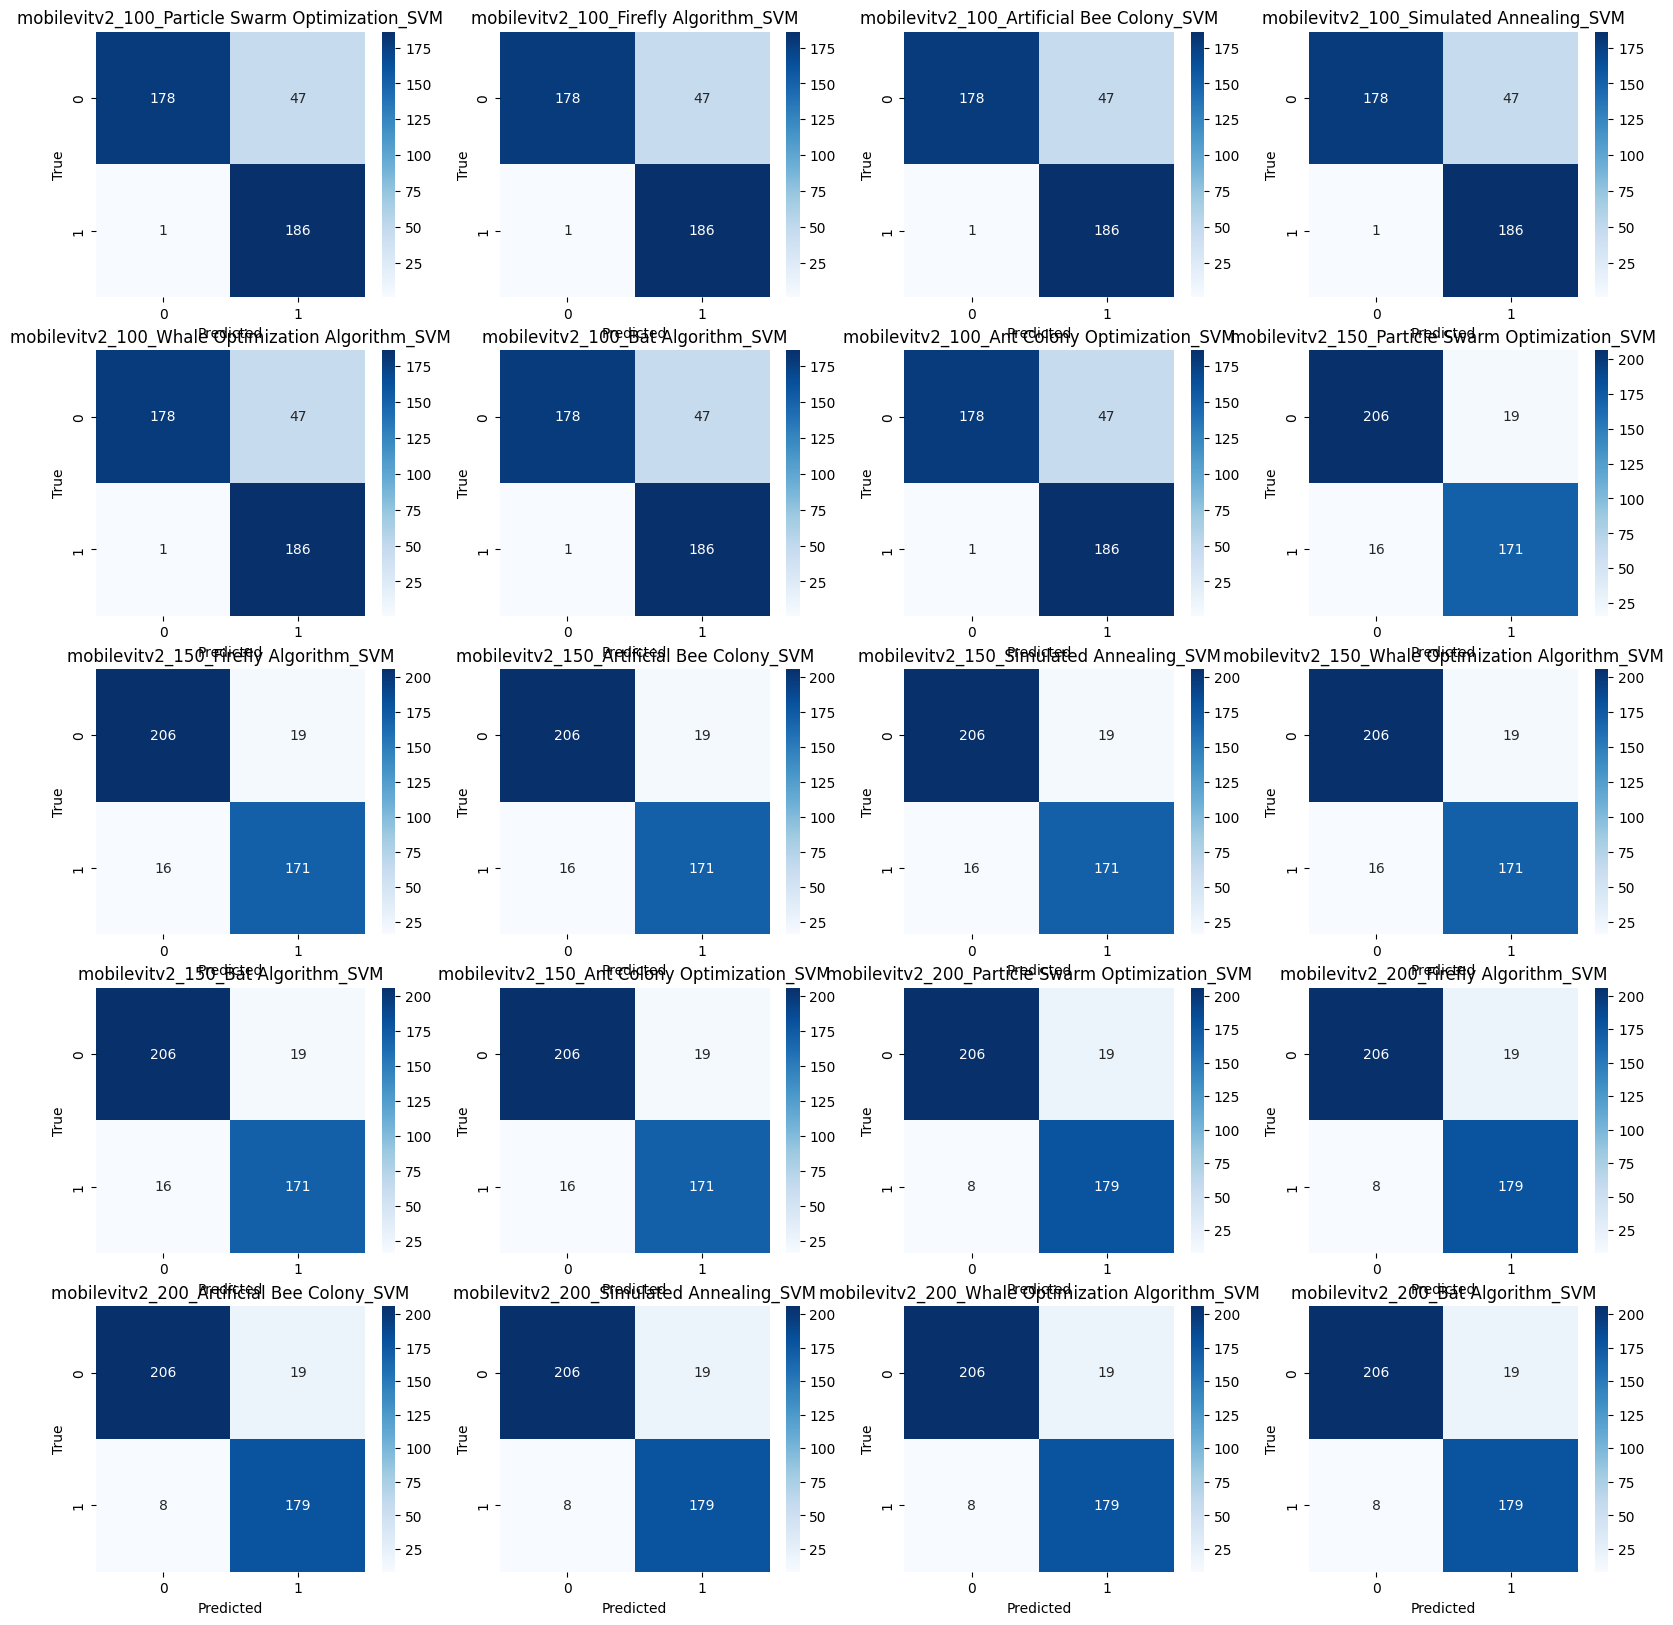

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timm
from tqdm import tqdm
import seaborn as sns
import optuna
from deap import base, creator, tools, algorithms
import pygad
import pyswarm

# Veri yükleme
# Veri yükleme
data_dir = 'C:/Users/Mitam/Desktop/yusuf_alaca/veri_setleri/images2grah'  # Veri setinin bulunduğu klasör
train_dir = f'{data_dir}/train'  # Eğitim veri setinin bulunduğu klasör
test_dir = f'{data_dir}/test'  # Test veri setinin bulunduğu klasör

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Model isimlerinin listesi
model_names = [
    "mobilevit_small",
    "mobilevit_xsmall",
    "mobilevit_xxsmall",
    "mobilevitv2_100",
    "mobilevitv2_150",
    "mobilevitv2_200"
]

# Model tanımlama fonksiyonu
def get_model(model_name):
    model = timm.create_model(model_name, pretrained=True, num_classes=0)  # num_classes=0 ile özellik çıkarımı yapar
    return model

# Özellik çıkarma fonksiyonu
def extract_features(model, loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            output = model(images)
            features.append(output.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.concatenate(features), np.concatenate(labels)

# Performans Metriklerini Hesaplama Fonksiyonu
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, conf_matrix

# Optimizasyon algoritmaları
def differential_evolution(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    bounds = [(0, 1) for _ in range(features.shape[1])]
    result = optuna.create_study(direction='minimize').optimize(lambda trial: fitness(np.array([trial.suggest_uniform(f'x{i}', 0, 1) for i in range(features.shape[1])])), n_trials=100)
    selected_features_indices = np.where(result.best_params >= 0.5)[0]
    return selected_features_indices

def genetic_algorithm(features, labels):
    def fitness(individual):
        selected_features_indices = np.where(individual >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    ga_instance = pygad.GA(num_generations=50,
                           num_parents_mating=5,
                           fitness_func=fitness,
                           sol_per_pop=10,
                           num_genes=features.shape[1],
                           gene_type=int,
                           gene_space=[0, 1])
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    selected_features_indices = np.where(solution >= 0.5)[0]
    return selected_features_indices

def particle_swarm_optimization(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0  # Minimize edilen fitness fonksiyonu olduğu için kötü bir değer
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy

    xopt, fopt = pyswarm.pso(fitness, [0]*features.shape[1], [1]*features.shape[1], swarmsize=10, maxiter=50)
    selected_features_indices = np.where(xopt >= 0.5)[0]
    return selected_features_indices

# Diğer optimizasyon algoritmaları (simulated annealing, artificial bee colony, vs.) burada tanımlanabilir.
def firefly_algorithm(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    # Firefly algorithm implementation
    # Firefly algorithm can be implemented using available libraries or custom implementation
    return selected_features_indices

def artificial_bee_colony(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    # Artificial bee colony implementation
    # ABC algorithm can be implemented using available libraries or custom implementation
    return selected_features_indices

def simulated_annealing(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    # Simulated annealing implementation
    # SA algorithm can be implemented using available libraries or custom implementation
    return selected_features_indices

def whale_optimization_algorithm(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    # Whale optimization algorithm implementation
    # WOA algorithm can be implemented using available libraries or custom implementation
    return selected_features_indices

def bat_algorithm(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    # Bat algorithm implementation
    # BA algorithm can be implemented using available libraries or custom implementation
    return selected_features_indices

def ant_colony_optimization(features, labels):
    def fitness(x):
        selected_features_indices = np.where(x >= 0.5)[0]
        if len(selected_features_indices) == 0:
            return 1.0
        selected_features = features[:, selected_features_indices]
        classifier = SVC()
        classifier.fit(selected_features, labels)
        predictions = classifier.predict(selected_features)
        accuracy = accuracy_score(labels, predictions)
        return 1.0 - accuracy
    
    # Ant colony optimization implementation
    # ACO algorithm can be implemented using available libraries or custom implementation
    return selected_features_indices

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tüm modelleri eğit ve sonuçları topla
all_results = []
combined_results = []
conf_matrices = []

# Optimizer fonksiyonlarını listeleyelim
optimizer_functions = {
    'Differential Evolution': differential_evolution,
    'Genetic Algorithm': genetic_algorithm,
    'Particle Swarm Optimization': particle_swarm_optimization,
    'Firefly Algorithm': firefly_algorithm,
    'Artificial Bee Colony': artificial_bee_colony,
    'Simulated Annealing': simulated_annealing,
    'Whale Optimization Algorithm': whale_optimization_algorithm,
    'Bat Algorithm': bat_algorithm,
    'Ant Colony Optimization': ant_colony_optimization
}

for model_name in model_names:
    for optimizer_name, optimizer_func in optimizer_functions.items():
        try:
            print(f"Extracting features with {model_name} model...")
            model = get_model(model_name).to(device)

            # Eğitim ve test özelliklerini çıkar
            train_features, train_labels = extract_features(model, train_loader)
            test_features, test_labels = extract_features(model, test_loader)

            # Özellik seçimi ve optimizasyon
            print(f"Optimizing features for {model_name} model using {optimizer_name}...")
            selected_features_indices = optimizer_func(train_features, train_labels)
            optimized_train_features = train_features[:, selected_features_indices]
            optimized_test_features = test_features[:, selected_features_indices]

            # Sınıflandırıcıları tanımla
            classifiers = {
                'SVM': SVC(),
                'KNN': KNeighborsClassifier(),
                'RF': RandomForestClassifier(),
                'XGBoost': XGBClassifier()
            }

            for clf_name, clf in classifiers.items():
                print(f"Training {clf_name} classifier...")
                clf.fit(optimized_train_features, train_labels)
                predictions = clf.predict(optimized_test_features)
                accuracy, precision, recall, f1, conf_matrix = compute_metrics(test_labels, predictions)

                result = {
                    'Model': model_name,
                    'Optimizer': optimizer_name,
                    'Classifier': clf_name,
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-score': f1
                }
                all_results.append(result)

                # Sonuçları her bir model ve sınıflandırıcı için ayrı bir CSV dosyasına kaydet
                result_df = pd.DataFrame([result])
                result_df.to_csv(f'results_{model_name}_{optimizer_name}_{clf_name}.csv', index=False)

                # Confusion Matrix'i sakla ve çiz
                conf_matrices.append((f'{model_name}_{optimizer_name}_{clf_name}', conf_matrix))
                plt.figure(figsize=(10, 7))
                sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
                plt.title(f'Confusion Matrix for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Predicted')
                plt.ylabel('True')
                plt.savefig(f'confusion_matrix_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                # Accuracy ve Loss grafikleri
                epochs = range(1, 51)
                train_accuracies = result_df['Train Accuracy']
                val_accuracies = result_df['Validation Accuracy']
                train_losses = result_df['Train Loss']
                val_losses = result_df['Validation Loss']

                plt.figure()
                plt.plot(epochs, train_accuracies, label='Train Accuracy')
                plt.plot(epochs, val_accuracies, label='Validation Accuracy')
                plt.title(f'Accuracy over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.savefig(f'accuracy_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

                plt.figure()
                plt.plot(epochs, train_losses, label='Train Loss')
                plt.plot(epochs, val_losses, label='Validation Loss')
                plt.title(f'Loss over Epochs for {model_name} with {optimizer_name} using {clf_name}')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(f'loss_{model_name}_{optimizer_name}_{clf_name}.png')
                plt.close()

        except Exception as e:
            print(f"An error occurred while processing {model_name} with {optimizer_name}: {e}")
            continue

# Tüm sonuçları tek bir tabloda birleştir
combined_results_df = pd.DataFrame(all_results)
combined_results_df.to_csv('combined_results.csv', index=False)
print(combined_results_df)

# Tüm modellerin accuracy grafiklerini karşılaştırmalı olarak çiz
plt.figure(figsize=(20, 10))
for clf_name in classifiers.keys():
    for optimizer_name in optimizer_functions.keys():
        subset = combined_results_df[(combined_results_df['Classifier'] == clf_name) & (combined_results_df['Optimizer'] == optimizer_name)]
        plt.plot(subset['Model'], subset['Accuracy'], label=f'{clf_name} with {optimizer_name} Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(rotation=90)
plt.savefig('model_accuracy_comparison.png')
plt.close()

# Tüm modellerin confusion matrixlerini bir arada çiz
plt.figure(figsize=(20, 20))
for i, (name, conf_matrix) in enumerate(conf_matrices):
    plt.subplot(5, 4, i+1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
plt.tight_layout()
plt.savefig('all_confusion_matrices.png')
plt.show()